# Render a HyperNeRF video!

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://hypernerf.github.io)]
[[Paper](https://arxiv.org/abs/2106.13228)]
[[GitHub](https://github.com/google/hypernerf)]

This notebook renders a video using the test cameras generated in the capture processing notebook.

You can also load your own custom cameras by modifying the code slightly.

### Instructions

1. Convert a video into our dataset format using the [capture processing notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Capture_Processing.ipynb).
2. Train a HyperNeRF model using the [training notebook](https://colab.sandbox.google.com/github/google/hypernerf/blob/main/notebooks/HyperNeRF_Training.ipynb)
3. Run this notebook!


### Notes
 * Please report issues on the [GitHub issue tracker](https://github.com/google/hypernerf/issues).

## Environment Setup

In [1]:
# !pip install flax immutabledict mediapy
# !pip install git+https://github.com/google/hypernerf

In [2]:
# @title Configure notebook runtime
# @markdown If you would like to use a GPU runtime instead, change the runtime type by going to `Runtime > Change runtime type`. 
# @markdown You will have to use a smaller batch size on GPU.

import jax

runtime_type = 'gpu'  # @param ['gpu', 'tpu']
if runtime_type == 'tpu':
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()

print('Detected Devices:', jax.devices())

Detected Devices: [GpuDevice(id=0, process_index=0)]


In [3]:
# # @title Mount Google Drive
# # @markdown Mount Google Drive onto `/content/gdrive`. You can skip this if running locally.

# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# @title Define imports and utility functions.

import jax
from jax.config import config as jax_config
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import flax
import flax.linen as nn
from flax import jax_utils
from flax import optim
from flax.metrics import tensorboard
from flax.training import checkpoints

from absl import logging
from io import BytesIO
import random as pyrandom
import numpy as np
import PIL
import IPython
import tempfile
import imageio
import mediapy
from IPython.display import display, HTML
from base64 import b64encode


# Monkey patch logging.
def myprint(msg, *args, **kwargs):
 print(msg % args)

logging.info = myprint 
logging.warn = myprint
logging.error = myprint

In [5]:
# @title Model and dataset configuration
# @markdown Change the directories to where you saved your capture and experiment.

import os

import sys
if os.path.exists(os.path.expanduser('~/hypernerf-barf/')):
    project_root = os.path.expanduser('~/hypernerf-barf/')
elif os.path.exists(os.path.expanduser('~/3d_cv/repos/hypernerf_barf/')):
    project_root = os.path.expanduser('~/3d_cv/repos/hypernerf_barf/')
else:
    raise NotImplemented
sys.path.insert(0, project_root)

if os.path.exists('/ssd/zhiwen/data/hypernerf/raw/'):
    data_root = '/ssd/zhiwen/data/hypernerf/raw/'
elif os.path.exists('/hdd/zhiwen/data/hypernerf/raw/'):
    data_root = '/hdd/zhiwen/data/hypernerf/raw/'
elif os.path.exists('/home/zwyan/3d_cv/data/hypernerf/raw/'):
    data_root = '/home/zwyan/3d_cv/data/hypernerf/raw/'
else:
    raise NotImplemented

from pathlib import Path
from pprint import pprint
import gin
from IPython.display import display, Markdown

from hypernerf import models
from hypernerf import modules
from hypernerf import warping
from hypernerf import datasets
from hypernerf import configs


# @markdown The working directory where the trained model is.
# train_dir = os.path.join(project_root, 'experiments/as7_q_base_exp01')  # @param {type: "string"}
# train_dir = os.path.join(project_root, 'experiments/wb5_test_base')  # @param {type: "string"}
# train_dir = os.path.join(project_root, 'experiments/wb5_hcxt_exp01')  # @param {type: "string"}
train_dir = os.path.join(project_root, 'experiments/p1_q_hcx_nv_exp05')  # @param {type: "string"}

# @markdown The directory to the dataset capture.
# data_dir = os.path.join(data_root, 'americano/')  # @param {type: "string"}
# data_dir = os.path.join(data_root, 'white-board-5/')  # @param {type: "string"}
# data_dir = os.path.join(data_root, 'aluminium-sheet-6/')  # @param {type: "string"}
# data_dir = os.path.join(data_root, 'aluminium-sheet-7_qualitative/')  # @param {type: "string"}
# data_dir = os.path.join(data_root, 'collect-americano/')  # @param {type: "string"}
# data_dir = os.path.join(data_root, 'vrig-chicken/')  # @param {type: "string"}
data_dir = os.path.join(data_root, 'plate-1_qualitative/')  # @param {type: "string"}

checkpoint_dir = Path(train_dir, 'checkpoints')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

config_path = Path(train_dir, 'config.gin')
with open(config_path, 'r') as f:
  logging.info('Loading config from %s', config_path)
  config_str = f.read()
gin.parse_config(config_str)

config_path = Path(train_dir, 'config.gin')
with open(config_path, 'w') as f:
  logging.info('Saving config to %s', config_path)
  f.write(config_str)
    
exp_config = configs.ExperimentConfig()
train_config = configs.TrainConfig()
eval_config = configs.EvalConfig()
spec_config = configs.SpecularConfig()

eval_config.chunk = 4096

display(Markdown(
    gin.config.markdown(gin.config_str())))

Loading config from /home/zwyan/3d_cv/repos/hypernerf_barf/experiments/p1_q_hcx_nv_exp05/config.gin
Saving config to /home/zwyan/3d_cv/repos/hypernerf_barf/experiments/p1_q_hcx_nv_exp05/config.gin


#### Macros:

    batch_size = 512
    CONSTANT_ELASTIC_LOSS_SCHED = {'type': 'constant', 'value': %elastic_init_weight}
    CONSTANT_HYPER_ALPHA_SCHED = ('constant', %hyper_point_max_deg)
    CONSTANT_NORM_INPUT_ALPHA_SCHED = {'type': 'constant', 'value': 4}
    CONSTANT_NORM_LOSS_WEIGHT_SCHED = {'type': 'constant', 'value': 0.001}
    data_dir = '/ssd/zhiwen/data/hypernerf/raw/plate-1_qualitative'
    DEFAULT_LR_SCHEDULE = \
        {'final_value': %final_lr,
         'initial_value': %init_lr,
         'num_steps': %max_steps,
         'type': 'exponential'}
    elastic_init_weight = 0.01
    final_lr = 1e-05
    hyper_num_dims = 2
    hyper_point_max_deg = 1
    hyper_point_min_deg = 0
    hyper_sheet_max_deg = 6
    hyper_sheet_min_deg = 0
    image_scale = 4
    init_lr = 0.001
    max_steps = 250000
    spatial_point_max_deg = 8
    spatial_point_min_deg = 0
    warp_max_deg = 4
    warp_min_deg = 0
    
#### Parameters for ExperimentConfig:

    ExperimentConfig.datasource_cls = @NerfiesDataSource
    ExperimentConfig.image_scale = %image_scale
    ExperimentConfig.random_seed = 0
    ExperimentConfig.subname = None
    
#### Parameters for warp/GLOEmbed:

    warp/GLOEmbed.num_dims = 8
    
#### Parameters for HyperSheetMLP:

    HyperSheetMLP.depth = 6
    HyperSheetMLP.max_deg = %hyper_sheet_max_deg
    HyperSheetMLP.min_deg = %hyper_sheet_min_deg
    HyperSheetMLP.output_channels = %hyper_num_dims
    HyperSheetMLP.skips = (4,)
    HyperSheetMLP.use_residual = False
    HyperSheetMLP.width = 64
    
#### Parameters for NerfiesDataSource:

    NerfiesDataSource.camera_type = 'json'
    NerfiesDataSource.data_dir = %data_dir
    NerfiesDataSource.shuffle_pixels = False
    NerfiesDataSource.test_camera_trajectory = 'orbit-mild'
    
#### Parameters for NerfModel:

    NerfModel.activation = @jax.nn.relu
    NerfModel.alpha_channels = 1
    NerfModel.hyper_c_hyper_input = False
    NerfModel.hyper_c_num_dims = 2
    NerfModel.hyper_embed_cls = @hyper/GLOEmbed
    NerfModel.hyper_embed_key = 'warp'
    NerfModel.hyper_point_max_deg = %hyper_point_max_deg
    NerfModel.hyper_point_min_deg = %hyper_point_min_deg
    NerfModel.hyper_sheet_mlp_cls = @HyperSheetMLP
    NerfModel.hyper_sheet_use_input_points = True
    NerfModel.hyper_slice_method = 'bendy_sheet'
    NerfModel.hyper_use_warp_embed = True
    NerfModel.nerf_embed_cls = @nerf/GLOEmbed
    NerfModel.nerf_embed_key = 'appearance'
    NerfModel.nerf_rgb_branch_depth = 1
    NerfModel.nerf_rgb_branch_width = 128
    NerfModel.nerf_skips = (4,)
    NerfModel.nerf_trunk_depth = 8
    NerfModel.nerf_trunk_width = 256
    NerfModel.noise_std = None
    NerfModel.norm_input_max_deg = 4
    NerfModel.norm_input_min_deg = 0
    NerfModel.norm_supervision_type = 'warped'
    NerfModel.norm_type = 'none'
    NerfModel.num_coarse_samples = 64
    NerfModel.num_fine_samples = 64
    NerfModel.predict_norm = True
    NerfModel.rgb_channels = 3
    NerfModel.spatial_point_max_deg = %spatial_point_max_deg
    NerfModel.spatial_point_min_deg = %spatial_point_min_deg
    NerfModel.stop_norm_gradient = True
    NerfModel.use_alpha_condition = False
    NerfModel.use_hyper_c = True
    NerfModel.use_hyper_c_embed = False
    NerfModel.use_linear_disparity = False
    NerfModel.use_nerf_embed = False
    NerfModel.use_norm_voxel = True
    NerfModel.use_posenc_identity = False
    NerfModel.use_ref_radiance = True
    NerfModel.use_rgb_condition = False
    NerfModel.use_sample_at_infinity = True
    NerfModel.use_stratified_sampling = True
    NerfModel.use_viewdirs = True
    NerfModel.use_viewdirs_in_hyper = False
    NerfModel.use_warp = True
    NerfModel.use_white_background = False
    NerfModel.use_x_in_rgb_condition = False
    NerfModel.viewdir_max_deg = 4
    NerfModel.viewdir_min_deg = 0
    NerfModel.warp_embed_cls = @warp/GLOEmbed
    NerfModel.warp_embed_key = 'warp'
    NerfModel.warp_field_cls = @SE3Field
    
#### Parameters for NormVoxels:

    NormVoxels.range_x_max = 1.5
    NormVoxels.range_x_min = -1.5
    NormVoxels.range_y_max = 1.5
    NormVoxels.range_y_min = -1.5
    NormVoxels.range_z_max = 1.5
    NormVoxels.range_z_min = -1.5
    NormVoxels.voxel_shape = (1000, 50, 50, 50, 3)
    
#### Parameters for SE3Field:

    SE3Field.hyper_depth = 0
    SE3Field.hyper_init = None
    SE3Field.hyper_width = 0
    SE3Field.max_deg = %warp_max_deg
    SE3Field.min_deg = %warp_min_deg
    SE3Field.norm = None
    SE3Field.num_hyper_dims = 0
    SE3Field.pivot_depth = 0
    SE3Field.pivot_width = 128
    SE3Field.rotation_depth = 0
    SE3Field.rotation_width = 128
    SE3Field.skips = (4,)
    SE3Field.translation_depth = 0
    SE3Field.translation_width = 128
    SE3Field.trunk_depth = 6
    SE3Field.trunk_width = 128
    SE3Field.use_posenc_identity = False
    
#### Parameters for SpecularConfig:

    SpecularConfig.back_facing_reg_weight = 0.1
    SpecularConfig.hyper_c_jacobian_reg_scale = 0.1
    SpecularConfig.hyper_c_jacobian_reg_weight = 3e-05
    SpecularConfig.hyper_concentration_reg_scale = 0.1
    SpecularConfig.hyper_concentration_reg_weight = 0.0001
    SpecularConfig.hyper_jacobian_reg_scale = 0.1
    SpecularConfig.hyper_jacobian_reg_weight = 3e-06
    SpecularConfig.norm_input_alpha_schedule = %CONSTANT_NORM_INPUT_ALPHA_SCHED
    SpecularConfig.norm_loss_weight_schedule = %CONSTANT_NORM_LOSS_WEIGHT_SCHED
    SpecularConfig.norm_voxel_loss_weight = 1000
    SpecularConfig.norm_voxel_lr_schedule = \
        {'final_value': 0.001,
         'initial_value': 0.1,
         'num_steps': 250000,
         'type': 'exponential'}
    SpecularConfig.screw_input_mode = None
    SpecularConfig.sigma_grad_diff_reg_weight = 0
    SpecularConfig.use_back_facing_reg = True
    SpecularConfig.use_hyper_c_jacobian_reg_loss = False
    SpecularConfig.use_hyper_concentration_reg_loss = False
    SpecularConfig.use_hyper_jacobian_reg_loss = False
    SpecularConfig.use_predicted_norm = True
    SpecularConfig.use_sigma_grad_diff_reg = False
    SpecularConfig.use_sigma_gradient = False
    
#### Parameters for TrainConfig:

    TrainConfig.background_loss_weight = 1.0
    TrainConfig.background_points_batch_size = 16384
    TrainConfig.batch_size = %batch_size
    TrainConfig.curvature_loss_alpha = 0
    TrainConfig.curvature_loss_scale = 0
    TrainConfig.curvature_loss_spacing = 0
    TrainConfig.curvature_loss_weight_schedule = None
    TrainConfig.elastic_loss_type = 'log_svals'
    TrainConfig.elastic_loss_weight_schedule = %CONSTANT_ELASTIC_LOSS_SCHED
    TrainConfig.elastic_reduce_method = 'weight'
    TrainConfig.histogram_every = 100
    TrainConfig.hyper_alpha_schedule = %CONSTANT_HYPER_ALPHA_SCHED
    TrainConfig.hyper_reg_loss_weight = 0.001
    TrainConfig.hyper_sheet_alpha_schedule = ('constant', %hyper_sheet_max_deg)
    TrainConfig.log_every = 100
    TrainConfig.lr_schedule = %DEFAULT_LR_SCHEDULE
    TrainConfig.max_steps = %max_steps
    TrainConfig.nerf_alpha_schedule = ('constant', %spatial_point_max_deg)
    TrainConfig.print_every = 100
    TrainConfig.save_every = 1000
    TrainConfig.shuffle_buffer_size = 5000000
    TrainConfig.use_background_loss = True
    TrainConfig.use_curvature_loss = False
    TrainConfig.use_elastic_loss = False
    TrainConfig.use_hyper_reg_loss = False
    TrainConfig.use_warp_reg_loss = True
    TrainConfig.use_weight_norm = False
    TrainConfig.warp_alpha_schedule = \
        {'final_value': %warp_max_deg,
         'initial_value': %warp_min_deg,
         'num_steps': 50000,
         'type': 'linear'}
    TrainConfig.warp_reg_loss_alpha = -2.0
    TrainConfig.warp_reg_loss_scale = 0.001
    TrainConfig.warp_reg_loss_weight = 0.001

*** Loading dataset IDs from /home/zwyan/3d_cv/data/hypernerf/raw/plate-1_qualitative/dataset.json
Creating datasource of type NerfiesDataSource with use_appearance_id=True, use_camera_id=False, use_warp_id=True, use_depth=False, use_time=False, train_stride=1, val_stride=1


""

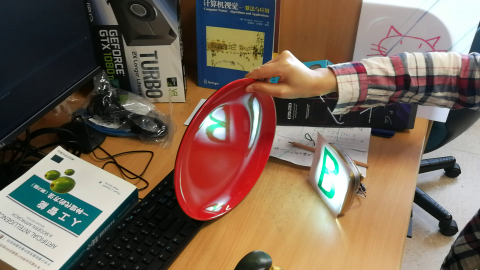

In [6]:
# @title Create datasource and show an example.

from hypernerf import datasets
from hypernerf import image_utils

dummy_model = models.NerfModel({}, 0, 0)
datasource = exp_config.datasource_cls(
    data_dir=data_dir,
    image_scale=exp_config.image_scale,
    random_seed=exp_config.random_seed,
    # Enable metadata based on model needs.
    use_warp_id=dummy_model.use_warp,
    use_appearance_id=(
        dummy_model.nerf_embed_key == 'appearance'
        or dummy_model.hyper_embed_key == 'appearance'),
    use_camera_id=dummy_model.nerf_embed_key == 'camera',
    use_time=dummy_model.warp_embed_key == 'time')

mediapy.show_image(datasource.load_rgb(datasource.train_ids[0]))

In [ ]:
# @title Load model
# @markdown Defines the model and initializes its parameters.

from flax.training import checkpoints
from hypernerf import models
from hypernerf import model_utils
from hypernerf import schedules
from hypernerf import training

rng = random.PRNGKey(exp_config.random_seed)
np.random.seed(exp_config.random_seed + jax.process_index())
devices_to_use = jax.devices()

learning_rate_sched = schedules.from_config(train_config.lr_schedule)
nerf_alpha_sched = schedules.from_config(train_config.nerf_alpha_schedule)
warp_alpha_sched = schedules.from_config(train_config.warp_alpha_schedule)
elastic_loss_weight_sched = schedules.from_config(
train_config.elastic_loss_weight_schedule)
hyper_alpha_sched = schedules.from_config(train_config.hyper_alpha_schedule)
hyper_sheet_alpha_sched = schedules.from_config(
    train_config.hyper_sheet_alpha_schedule)
norm_loss_weight_sched = schedules.from_config(spec_config.norm_loss_weight_schedule)
norm_input_alpha_sched = schedules.from_config(spec_config.norm_input_alpha_schedule)
norm_voxel_lr_sched = schedules.from_config(spec_config.norm_voxel_lr_schedule)
norm_voxel_ratio_sched = schedules.from_config(spec_config.norm_voxel_ratio_schedule)

rng, key = random.split(rng)
params = {}
model, params['model'] = models.construct_nerf(
      key,
      batch_size=train_config.batch_size,
      embeddings_dict=datasource.embeddings_dict,
      near=datasource.near,
      far=datasource.far,
      screw_input_mode=spec_config.screw_input_mode,
      use_sigma_gradient=spec_config.use_sigma_gradient,
      use_predicted_norm=spec_config.use_predicted_norm,
)

optimizer_def = optim.Adam(learning_rate_sched(0))
optimizer = optimizer_def.create(params)

state = model_utils.TrainState(
    optimizer=optimizer,
    nerf_alpha=nerf_alpha_sched(0),
    warp_alpha=warp_alpha_sched(0),
    hyper_alpha=hyper_alpha_sched(0),
    hyper_sheet_alpha=hyper_sheet_alpha_sched(0),
    norm_loss_weight=norm_loss_weight_sched(0),
    norm_input_alpha=norm_input_alpha_sched(0),
    norm_voxel_lr=norm_voxel_lr_sched(0),
    norm_voxel_ratio=norm_voxel_ratio_sched(0),
)
scalar_params = training.ScalarParams(
  learning_rate=learning_rate_sched(0),
  elastic_loss_weight=elastic_loss_weight_sched(0),
  warp_reg_loss_weight=train_config.warp_reg_loss_weight,
  warp_reg_loss_alpha=train_config.warp_reg_loss_alpha,
  warp_reg_loss_scale=train_config.warp_reg_loss_scale,
  background_loss_weight=train_config.background_loss_weight,
  hyper_reg_loss_weight=train_config.hyper_reg_loss_weight,
  sigma_grad_diff_reg_weight=spec_config.sigma_grad_diff_reg_weight,
  back_facing_reg_weight=spec_config.back_facing_reg_weight,
  hyper_concentration_reg_weight=spec_config.hyper_concentration_reg_weight,
  hyper_concentration_reg_scale=spec_config.hyper_concentration_reg_scale,
  hyper_jacobian_reg_weight=spec_config.hyper_jacobian_reg_weight,
  hyper_jacobian_reg_scale=spec_config.hyper_jacobian_reg_scale,
  hyper_c_jacobian_reg_weight=spec_config.hyper_c_jacobian_reg_weight,
  hyper_c_jacobian_reg_scale=spec_config.hyper_c_jacobian_reg_scale,
  norm_voxel_loss_weight=spec_config.norm_voxel_loss_weight,
)

logging.info('Restoring checkpoint from %s', checkpoint_dir)
state = checkpoints.restore_checkpoint(checkpoint_dir, state)
step = state.optimizer.state.step + 1
state = jax_utils.replicate(state, devices=devices_to_use)
del params

/home/zwyan/miniconda3/envs/hypernerf/lib/python3.8/site-packages/flax/optim/base.py:49: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  warnings.warn(


Restoring checkpoint from /home/zwyan/3d_cv/repos/hypernerf_barf/experiments/p1_q_hcx_nv_exp05/checkpoints
Restoring checkpoint from /home/zwyan/3d_cv/repos/hypernerf_barf/experiments/p1_q_hcx_nv_exp05/checkpoints/checkpoint_49000


In [ ]:
# @title Define pmapped render function.

import functools
from hypernerf import evaluation

devices = jax.devices()


def _model_fn(key_0, key_1, key_2, params, rays_dict, extra_params):
  out = model.apply({'params': params},
                    rays_dict,
                    extra_params=extra_params,
                    rngs={
                        'coarse': key_0,
                        'fine': key_1,
                        'voxel': key_2
                    },
                    mutable=False,
                    screw_input_mode=spec_config.screw_input_mode,
                    use_sigma_gradient=spec_config.use_sigma_gradient,
                    use_predicted_norm=spec_config.use_predicted_norm,
                    return_points=False,
                    return_nv_details=False,
                    norm_voxel_ratio=1, # inference ratio is always 1
                   )
  return jax.lax.all_gather(out, axis_name='batch')

pmodel_fn = jax.pmap(
    # Note rng_keys are useless in eval mode since there's no randomness.
    _model_fn,
    in_axes=(0, 0, 0, 0, 0, 0),  # Only distribute the data input.
    devices=devices_to_use,
    axis_name='batch',
)

render_fn = functools.partial(evaluation.render_image,
                              model_fn=pmodel_fn,
                              device_count=len(devices),
                              chunk=eval_config.chunk)

In [ ]:
# @title Load cameras.

from hypernerf import utils

# camera_path = 'camera'
# camera_path = 'fix_camera_0'  # @param {type: 'string'}
# camera_path = 'fix_camera_92'  # @param {type: 'string'}
camera_path = 'fix_camera_93'  # @param {type: 'string'}
# camera_path = 'fix_camera_270'  # @param {type: 'string'}
# camera_path = 'vrig_camera'  # @param {type: 'string'}
# camera_path = 'interpolate_camera'  # @param {type: 'string'}

camera_dir = Path(data_dir, camera_path)
print(f'Loading cameras from {camera_dir}')
test_camera_paths = datasource.glob_cameras(camera_dir)
test_cameras = utils.parallel_map(datasource.load_camera, test_camera_paths, show_pbar=True)

In [ ]:
# @title Render video frames.
from hypernerf import visualization as viz
from hypernerf import model_utils


rng = rng + jax.process_index()  # Make random seed separate across hosts.
keys = random.split(rng, len(devices))

results = []
raw_result_list = []
step_size = 9 if camera_path.startswith("vrig") else 10

for i in range(0, len(test_cameras), step_size):
# for i in range(330, 400):
  print(f'Rendering frame {i+1}/{len(test_cameras)}')
  camera = test_cameras[i]
  batch = datasets.camera_to_rays(camera)
  if not camera_path.startswith('vrig'):
    batch['metadata'] = {
        'appearance': jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32) * i,
        'warp': jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32) * i,
        'camera': jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32) * 0
    }
  else:
    batch['metadata'] = {
#         'appearance': jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32) * ((i + 1) % 2 + 1),
        'appearance': jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32) * i,
        'warp': jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32) * i,
        'camera': jnp.ones_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32) * ((i + 1) % 2 + 1)
    }

  render = render_fn(state, batch, rng=rng)
#   raw_result = {}
#   for key in render:
#     raw_result[key] = np.array(render[key])
#   raw_result_list.append(raw_result)

  rgb = np.array(render['rgb'])
  depth_med = np.array(render['med_depth'])

  sigma_gradient = np.array(render['ray_sigma_gradient'])
  sigma_gradient = model_utils.normalize_vector(sigma_gradient)
  sigma_gradient = sigma_gradient / 2.0 + 0.5

  sigma_gradient_r = np.array(render['ray_sigma_gradient_r'])
  sigma_gradient_r = sigma_gradient_r / 2.0 + 0.5
    
  if 'ray_inter_norm' in render:
      ray_inter_norm = np.array(render['ray_inter_norm'])
      ray_inter_norm = ray_inter_norm / 2.0 + 0.5
  else:
    ray_inter_norm = np.zeros_like(sigma_gradient)

  ray_rotation_field = np.array(render['ray_rotation_field'])
  ray_rotation_field = ray_rotation_field / 2.0 + 0.5
    
  ray_translation_field = np.array(render['ray_translation_field'])
  ray_translation_field = np.abs(ray_translation_field) / 0.03
    
  ray_hyper_points = np.array(render['ray_hyper_points'])
  ray_hyper_points = np.abs(ray_hyper_points)
#   print(ray_hyper_points)
  ray_hyper_points = ray_hyper_points / np.max(ray_hyper_points)
  dummy_hyper = np.ones([ray_hyper_points.shape[0], ray_hyper_points.shape[1], 1]) * 0
  ray_hyper_points = np.concatenate([ray_hyper_points, dummy_hyper], axis=-1)
#   print(np.max(ray_hyper_points, axis=1))

  ray_hyper_c = np.array(render['ray_hyper_c'])
  ray_hyper_c = np.abs(ray_hyper_c)
  ray_hyper_c = ray_hyper_c / np.max(ray_hyper_c)
  if ray_hyper_c.shape[-1] == 2:
    dummy_hyper_c = np.ones([ray_hyper_c.shape[0], ray_hyper_c.shape[1], 1]) * 0
    ray_hyper_c = np.concatenate([ray_hyper_c, dummy_hyper], axis=-1)
  else:
    ray_hyper_c = ray_hyper_c[..., :3]

  dummy_image = np.zeros_like(rgb)

  results.append((rgb, depth_med, sigma_gradient, ray_inter_norm, 
                  ray_rotation_field, ray_translation_field, ray_hyper_points, ray_hyper_c, dummy_image))
  depth_viz = viz.colorize(depth_med.squeeze(), cmin=datasource.near, cmax=datasource.far, invert=True)
  mediapy.show_images([rgb, depth_viz, sigma_gradient, ray_inter_norm, 
                       ray_rotation_field, ray_translation_field, ray_hyper_points, ray_hyper_c], columns=4)

In [ ]:
# @title Show rendered video.

fps = 30  # @param {type:'number'}

frames = []
for rgb, depth, sigma_gradient, ray_inter_norm, ray_rotation_field, ray_translation_field, ray_hyper_points, ray_hyper_c, dummy_image in results:
  depth_viz = viz.colorize(depth.squeeze(), cmin=datasource.near, cmax=datasource.far, invert=True)
#   frame = np.concatenate([rgb, depth_viz, sigma_gradient, sigma_gradient_r, 
#                           ray_rotation_field, ray_hyper_points, ray_hyper_c], axis=1)
  row1 = np.concatenate([rgb, depth_viz, sigma_gradient, ray_inter_norm], axis=1)
  row2 = np.concatenate([ray_rotation_field, ray_translation_field, ray_hyper_points, ray_hyper_c], axis=1)
  frame = np.concatenate([row1, row2], axis=0)
  frames.append(image_utils.image_to_uint8(frame))

mediapy.set_show_save_dir(train_dir)
mediapy.show_video(frames, fps=fps, title="result_{}".format(camera_path))

In [ ]:
raw_result_save_path = os.path.join(train_dir, "render_result_{}".format(camera_path))
with open(raw_result_save_path, "wb+") as f:
    np.save(f, raw_result_list)

In [ ]:
import matplotlib.pyplot as plt
from jax import numpy as jnp

import os

import sys
if os.path.exists(os.path.expanduser('~/hypernerf-barf/')):
    project_root = os.path.expanduser('~/hypernerf-barf/')
elif os.path.exists(os.path.expanduser('~/3d_cv/repos/hypernerf_barf/')):
    project_root = os.path.expanduser('~/3d_cv/repos/hypernerf_barf/')
else:
    raise NotImplemented
sys.path.insert(0, project_root)
from hypernerf import utils

hyper_points = jnp.array([0, -0.05, -0.1, -0.3, -0.4, -0.5, -0.8, -1.2])
hyper_points = jnp.arange(-5, 5, 0.1)
# hyper_concentration_reg_loss = utils.general_loss_with_squared_residual(
# hyper_points, alpha=-2, scale=0.1
# )
hyper_concentration_reg_loss = utils.gm_loss(hyper_points, scale=0.1)
# print(hyper_concentration_reg_loss)
# print(spec_config.hyper_concentration_reg_scale)
plt.plot(hyper_points, hyper_concentration_reg_loss)
plt.show()

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")